In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
from scipy import stats
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings('ignore')

In [30]:
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

<h1>Data Loading</h1>

In [33]:
try:
    customers_df = pd.read_csv("../data/processed/customers_processed.csv")
    orders_df = pd.read_csv("../data/processed/orders_processed.csv")
    
    print(f"Customers dataset loaded: {customers_df.shape}")
    print(f"Orders dataset loaded: {orders_df.shape}")
    
except FileNotFoundError:
    print("Files not found. Please ensure the CSV files are in the correct path.")
    print("Expected files: 'customers_df.csv', 'orders_df.csv'")

Customers dataset loaded: (99092, 5)
Orders dataset loaded: (99092, 8)


<h1>Data Preparation</h1>

In [35]:
date_columns = [
    'order_purchase_dt', 'order_approved_dt', 
    'order_delivered_carrier_dt', 'order_delivered_customer_dt', 
    'order_estimated_delivery_dt'
]

for col in date_columns:
    if col in orders_df.columns:
        orders_df[col] = pd.to_datetime(orders_df[col], errors='coerce')
        print(f"Converted {col} to datetime")

Converted order_purchase_dt to datetime
Converted order_approved_dt to datetime
Converted order_delivered_carrier_dt to datetime
Converted order_delivered_customer_dt to datetime
Converted order_estimated_delivery_dt to datetime


In [37]:
business_df = orders_df.merge(customers_df, on='customer_id', how='left')

print(f"Data merged successfully: {business_df.shape[0]} records")
print(f"Date range: {business_df['order_purchase_dt'].min()} to {business_df['order_purchase_dt'].max()}")

Data merged successfully: 99092 records
Date range: 2017-01-05 11:56:06 to 2018-08-31 16:13:44


In [38]:
business_df['order_year'] = business_df['order_purchase_dt'].dt.year
business_df['order_month'] = business_df['order_purchase_dt'].dt.month
business_df['order_year_month'] = business_df['order_purchase_dt'].dt.to_period('M')
business_df['order_quarter'] = business_df['order_purchase_dt'].dt.quarter
business_df['order_weekday'] = business_df['order_purchase_dt'].dt.dayofweek
business_df['order_day'] = business_df['order_purchase_dt'].dt.day

print(f"Temporal features created for {business_df['order_year_month'].nunique()} unique months")

Temporal features created for 20 unique months


<h1>Holidays and Events Performance (Brazil)</h1>

In [39]:
brazilian_events = {
    'Black Friday': [(11, 'November')],  
    'Christmas Season': [(12, 'December')],
    'New Year': [(1, 'January')],
    'Mothers Day Brazil': [(5, 'May')],  
    'Fathers Day Brazil': [(8, 'August')], 
    'Valentine Day Brazil': [(6, 'June')],  
    'Back to School': [(2, 'February')],
    'Mid Year Sales': [(7, 'July')],
    'Easter Season': [(3, 'March'), (4, 'April')],  
}

def identify_shopping_season(row):
    month = row['order_month']
    
    if month == 11: 
        return 'Black Friday'
    elif month == 12:  
        return 'Christmas Season'
    elif month == 1: 
        return 'New Year'
    elif month == 5:  
        return 'Mothers Day'
    elif month == 8: 
        return 'Fathers Day'
    elif month == 6:  
        return 'Valentine Day Brazil'
    elif month == 2:  
        return 'Back to School'
    elif month == 7:  
        return 'Mid Year Sales'
    elif month in [3, 4]:  
        return 'Easter Season'
    else:
        return 'Regular'

business_df['shopping_season'] = business_df.apply(identify_shopping_season, axis=1)

print(f"Shopping seasons identified:")
season_counts = business_df['shopping_season'].value_counts()
for season, count in season_counts.items():
    print(f"   • {season}: {count:,} orders")

Shopping seasons identified:
   • Easter Season: 19,236 orders
   • Fathers Day: 10,843 orders
   • Mothers Day: 10,573 orders
   • Mid Year Sales: 10,318 orders
   • Valentine Day Brazil: 9,412 orders
   • Regular: 8,916 orders
   • Back to School: 8,508 orders
   • New Year: 8,069 orders
   • Black Friday: 7,544 orders
   • Christmas Season: 5,673 orders


<h1>1. Temporal Trends and Seasonality Analysis</h1>

In [40]:
monthly_trends = business_df.groupby('order_year_month').agg({
    'customer_id': 'count',
    'customer_unique_id': 'nunique',
    'customer_state': 'nunique'
}).reset_index()

monthly_trends.columns = ['year_month', 'total_orders', 'unique_customers', 'states_served']
monthly_trends['year_month_str'] = monthly_trends['year_month'].astype(str)

In [41]:
monthly_trends = monthly_trends.sort_values('year_month')
monthly_trends['mom_order_growth'] = monthly_trends['total_orders'].pct_change() * 100
monthly_trends['mom_customer_growth'] = monthly_trends['unique_customers'].pct_change() * 100

In [42]:
print(f"{'Month':<10} {'Orders':<8} {'Customers':<12} {'States':<8} {'Order Growth %':<15} {'Customer Growth %'}")

for _, row in monthly_trends.tail(10).iterrows():  # Show last 10 months
    order_growth = f"{row['mom_order_growth']:+.1f}%" if not pd.isna(row['mom_order_growth']) else "N/A"
    customer_growth = f"{row['mom_customer_growth']:+.1f}%" if not pd.isna(row['mom_customer_growth']) else "N/A"
    
    print(f"{row['year_month_str']:<10} {row['total_orders']:<8,} {row['unique_customers']:<12,} "
          f"{row['states_served']:<8} {order_growth:<15} {customer_growth}")

Month      Orders   Customers    States   Order Growth %  Customer Growth %
2017-11    7,544    7,430        27       +62.9%          +62.9%
2017-12    5,673    5,603        26       -24.8%          -24.6%
2018-01    7,269    7,166        27       +28.1%          +27.9%
2018-02    6,728    6,569        27       -7.4%           -8.3%
2018-03    7,211    7,115        27       +7.2%           +8.3%
2018-04    6,939    6,882        27       -3.8%           -3.3%
2018-05    6,873    6,814        27       -1.0%           -1.0%
2018-06    6,167    6,128        27       -10.3%          -10.1%
2018-07    6,292    6,230        27       +2.0%           +1.7%
2018-08    6,512    6,460        26       +3.5%           +3.7%


<H3>BRAZILIAN SHOPPING SEASONS PERFORMANCE:</H3>

In [43]:
seasonal_performance = business_df.groupby('shopping_season').agg({
    'customer_id': 'count',
    'customer_unique_id': 'nunique',
}).reset_index()

seasonal_performance.columns = ['shopping_season', 'total_orders', 'unique_customers']
seasonal_performance['avg_orders_per_customer'] = (
    seasonal_performance['total_orders'] / seasonal_performance['unique_customers']
).round(2)

seasonal_performance = seasonal_performance.sort_values('total_orders', ascending=False)

print(f"{'SEASON':<20} {'ORDERS':<10} {'CUSTOMERS':<12} {'ORDERS/Customer':<15}")

for _, row in seasonal_performance.iterrows():
    print(f"{row['shopping_season']:<20} {row['total_orders']:<10,} {row['unique_customers']:<12,} {row['avg_orders_per_customer']:<15}")

SEASON               ORDERS     CUSTOMERS    ORDERS/Customer
Easter Season        19,236     18,949       1.02           
Fathers Day          10,843     10,699       1.01           
Mothers Day          10,573     10,430       1.01           
Mid Year Sales       10,318     10,171       1.01           
Valentine Day Brazil 9,412      9,302        1.01           
Regular              8,916      8,741        1.02           
Back to School       8,508      8,321        1.02           
New Year             8,069      7,925        1.02           
Black Friday         7,544      7,430        1.02           
Christmas Season     5,673      5,603        1.01           


<H3>CreatingTemporal Visualization</H3>

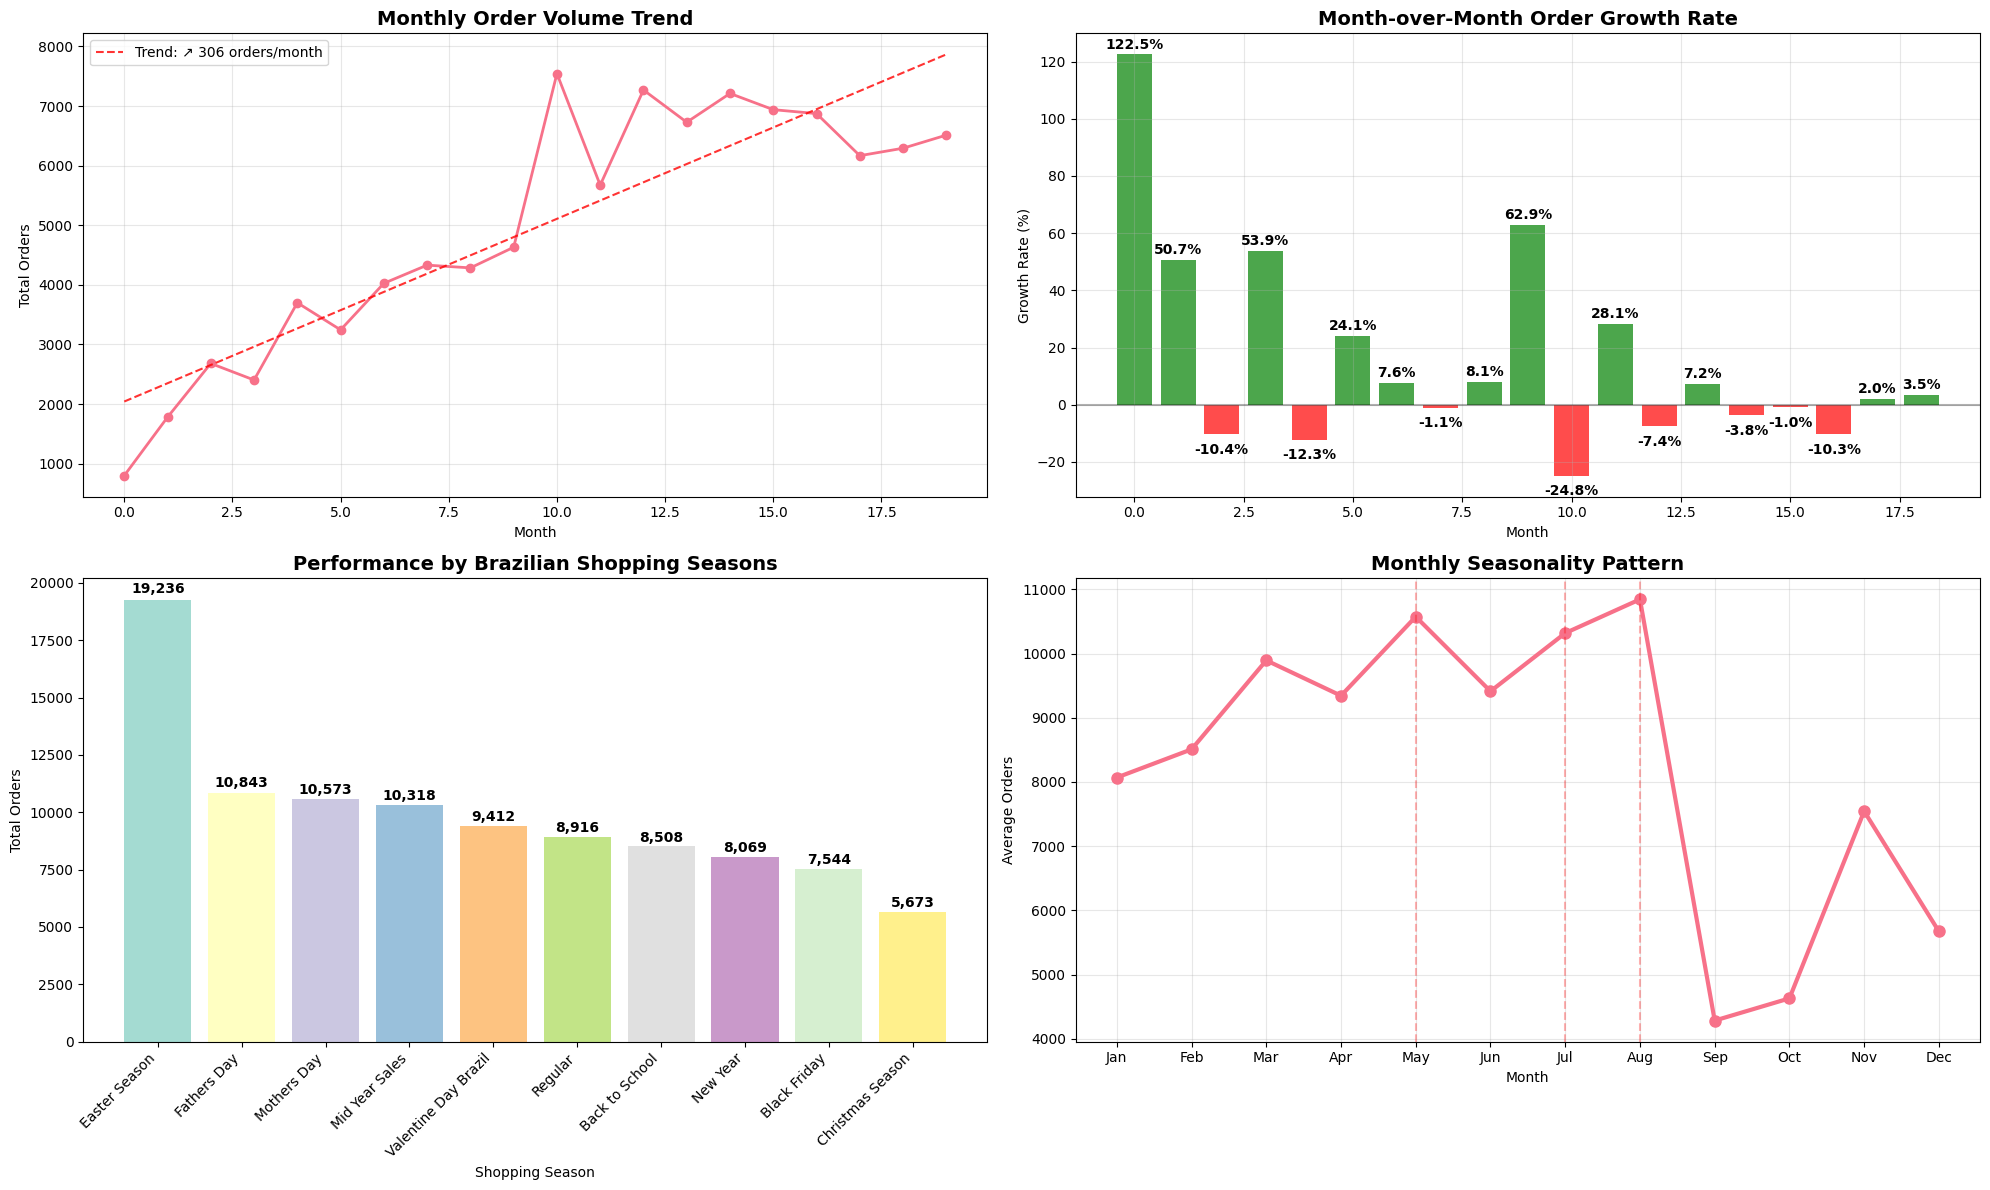

In [44]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 12))

# Plot 1: Monthly Order Volume Trend
ax1.plot(monthly_trends.index, monthly_trends['total_orders'], marker='o', linewidth=2, markersize=6)
ax1.set_title('Monthly Order Volume Trend', fontsize=14, fontweight='bold')
ax1.set_ylabel('Total Orders')
ax1.set_xlabel('Month')
ax1.grid(True, alpha=0.3)

# Add trend line
z = np.polyfit(monthly_trends.index, monthly_trends['total_orders'], 1)
p = np.poly1d(z)
ax1.plot(monthly_trends.index, p(monthly_trends.index), "--", alpha=0.8, color='red', 
         label=f'Trend: {"↗" if z[0] > 0 else "↘"} {abs(z[0]):.0f} orders/month')
ax1.legend()

# Plot 2: Month-over-Month Growth Rates
valid_growth = monthly_trends.dropna(subset=['mom_order_growth'])
colors = ['green' if x >= 0 else 'red' for x in valid_growth['mom_order_growth']]

bars = ax2.bar(range(len(valid_growth)), valid_growth['mom_order_growth'], color=colors, alpha=0.7)
ax2.set_title('Month-over-Month Order Growth Rate', fontsize=14, fontweight='bold')
ax2.set_ylabel('Growth Rate (%)')
ax2.set_xlabel('Month')
ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)
ax2.grid(True, alpha=0.3)

# Add value labels on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + (1 if height >= 0 else -3),
             f'{height:.1f}%', ha='center', va='bottom' if height >= 0 else 'top', fontweight='bold')

# Plot 3: Shopping Seasons Performance
season_colors = plt.cm.Set3(np.linspace(0, 1, len(seasonal_performance)))
bars = ax3.bar(range(len(seasonal_performance)), seasonal_performance['total_orders'], 
               color=season_colors, alpha=0.8)

ax3.set_title('Performance by Brazilian Shopping Seasons', fontsize=14, fontweight='bold')
ax3.set_ylabel('Total Orders')
ax3.set_xlabel('Shopping Season')
ax3.set_xticks(range(len(seasonal_performance)))
ax3.set_xticklabels(seasonal_performance['shopping_season'], rotation=45, ha='right')

# Add value labels on bars
for bar, orders in zip(bars, seasonal_performance['total_orders']):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
             f'{orders:,}', ha='center', va='bottom', fontweight='bold')

# Plot 4: Monthly Seasonality Pattern (Average by Month)
monthly_pattern = business_df.groupby('order_month')['customer_id'].count().reset_index()
monthly_pattern.columns = ['month', 'avg_orders']
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

ax4.plot(monthly_pattern['month'], monthly_pattern['avg_orders'], marker='o', linewidth=3, markersize=8)
ax4.set_title('Monthly Seasonality Pattern', fontsize=14, fontweight='bold')
ax4.set_ylabel('Average Orders')
ax4.set_xlabel('Month')
ax4.set_xticks(range(1, 13))
ax4.set_xticklabels(month_names)
ax4.grid(True, alpha=0.3)

# Highlight peak months
peak_months = monthly_pattern.nlargest(3, 'avg_orders')['month'].values
for month in peak_months:
    ax4.axvline(x=month, color='red', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

<h5>On average, monthly orders grew by 306 orders, showing steady growth despite some ups and downs. Seasonal events strongly shape demand, with Easter leading at 19,236 orders, almost double that of Father’s Day (10,450) and Mother’s Day (10,232). In contrast, global events like Black Friday (7,544) and Christmas (5,673) attract fewer sales in Brazil. Demand also peaks in March, May, July, and August, then dips in September and October before rising again in November, though Christmas remains weaker. This shows that customer demand in Brazil is driven more by local holidays and sales events than by global shopping traditions.</h5>

<H1>2. Geographic Performance Patterns</H1>

In [45]:
regional_performance = business_df.groupby('customer_state').agg({
    'customer_id': 'count',
    'customer_unique_id': 'nunique',
    'customer_city': 'nunique'
}).reset_index()

regional_performance.columns = ['state', 'total_orders', 'unique_customers', 'cities_served']
regional_performance['orders_per_customer'] = (
    regional_performance['total_orders'] / regional_performance['unique_customers']
).round(2)
regional_performance['market_share'] = (
    regional_performance['total_orders'] / regional_performance['total_orders'].sum() * 100
).round(2)

regional_performance = regional_performance.sort_values('total_orders', ascending=False)

In [46]:
print(f"{'STATE':<6} {'ORDERS':<8} {'CUSTOMERS':<10} {'CITIES':<8} {'ORDERS/CUSTOMERS':<15} {'Market Share %':<15}")

top_regions = regional_performance.head(5)
for _, row in top_regions.iterrows():
    print(f"{row['state']:<6} {row['total_orders']:<8,} {row['unique_customers']:<10,} "
          f"{row['cities_served']:<8} {row['orders_per_customer']:<15} {row['market_share']:<15}")

STATE  ORDERS   CUSTOMERS  CITIES   ORDERS/CUSTOMERS Market Share % 
SP     41,621   40,186     629      1.04            42.0           
RJ     12,792   12,330     148      1.04            12.91          
MG     11,591   11,222     745      1.03            11.7           
RS     5,441    5,252      379      1.04            5.49           
PR     5,025    4,863      364      1.03            5.07           


In [47]:
business_df['period'] = business_df['order_purchase_dt'].apply(
    lambda x: 'Early' if x < business_df['order_purchase_dt'].quantile(0.5) else 'Late'
)

growth_analysis = business_df.groupby(['customer_state', 'period']).agg({
    'customer_id': 'count'
}).reset_index().pivot(index='customer_state', columns='period', values='customer_id').fillna(0)

growth_analysis['growth_rate'] = ((growth_analysis['Late'] - growth_analysis['Early']) / 
                                 growth_analysis['Early'] * 100).round(2)
growth_analysis['total_orders'] = growth_analysis['Early'] + growth_analysis['Late']

In [48]:
growth_analysis = growth_analysis[growth_analysis['total_orders'] >= 100]
growth_analysis = growth_analysis.sort_values('growth_rate', ascending=False)

print(f"\nREGIONAL GROWTH PATTERNS (Early vs Late Period):")
print("-" * 70)
print(f"{'State':<6} {'Early Period':<12} {'Late Period':<12} {'Growth Rate %':<15} {'Classification':<15}")
print("-" * 70)

for state, row in growth_analysis.head(10).iterrows():
    if row['growth_rate'] > 50:
        classification = "High Growth"
    elif row['growth_rate'] > 0:
        classification = "Growing"
    elif row['growth_rate'] > -25:
        classification = "Declining"
    else:
        classification = "⚠️Sharp Decline"
    
    print(f"{state:<6} {row['Early']:<12,.0f} {row['Late']:<12,.0f} {row['growth_rate']:<15} {classification}")



REGIONAL GROWTH PATTERNS (Early vs Late Period):
----------------------------------------------------------------------
State  Early Period Late Period  Growth Rate %   Classification 
----------------------------------------------------------------------
DF     1,002        1,132        12.97           Growing
SP     19,623       21,998       12.1            Growing
MS     348          367          5.46            Growing
PR     2,493        2,532        1.56            Growing
PE     829          816          -1.57           Declining
MG     5,934        5,657        -4.67           Declining
MT     469          435          -7.25           Declining
BA     1,755        1,621        -7.64           Declining
TO     146          134          -8.22           Declining
ES     1,060        969          -8.58           Declining


In [49]:
def classify_market_maturity(row):
    orders = row['total_orders']
    cities = row['cities_served']
    orders_per_customer = row['orders_per_customer']
    
    if orders >= 5000 and cities >= 50 and orders_per_customer >= 1.2:
        return 'Established'
    elif orders >= 1000 and orders >= 500:
        return 'Growing' 
    elif orders >= 100:
        return 'Emerging'
    else:
        return 'Nascent'

regional_performance['market_maturity'] = regional_performance.apply(classify_market_maturity, axis=1)

maturity_analysis = regional_performance.groupby('market_maturity').agg({
    'state': 'count',
    'total_orders': 'sum',
    'unique_customers': 'sum'
}).reset_index()

maturity_analysis.columns = ['maturity_level', 'num_states', 'total_orders', 'total_customers']
maturity_analysis['avg_orders_per_state'] = (maturity_analysis['total_orders'] / 
                                            maturity_analysis['num_states']).round(0)

print(f"\nMARKET MATURITY CLASSIFICATION:")
print("-" * 75)
print(f"{'MATURITY LEVEL':<15} {'States':<8} {'Total Orders':<15} {'Avg Orders/State':<18}")
print("-" * 75)

for _, row in maturity_analysis.iterrows():
    print(f"{row['maturity_level']:<15} {row['num_states']:<8} {row['total_orders']:<15,} {row['avg_orders_per_state']:<18,.0f}")



MARKET MATURITY CLASSIFICATION:
---------------------------------------------------------------------------
MATURITY LEVEL  States   Total Orders    Avg Orders/State  
---------------------------------------------------------------------------
Emerging        12       6,281           523               
Growing         12       92,618          7,718             
Nascent         3        193             64                


<h3> Geographic Visualizations</h3>

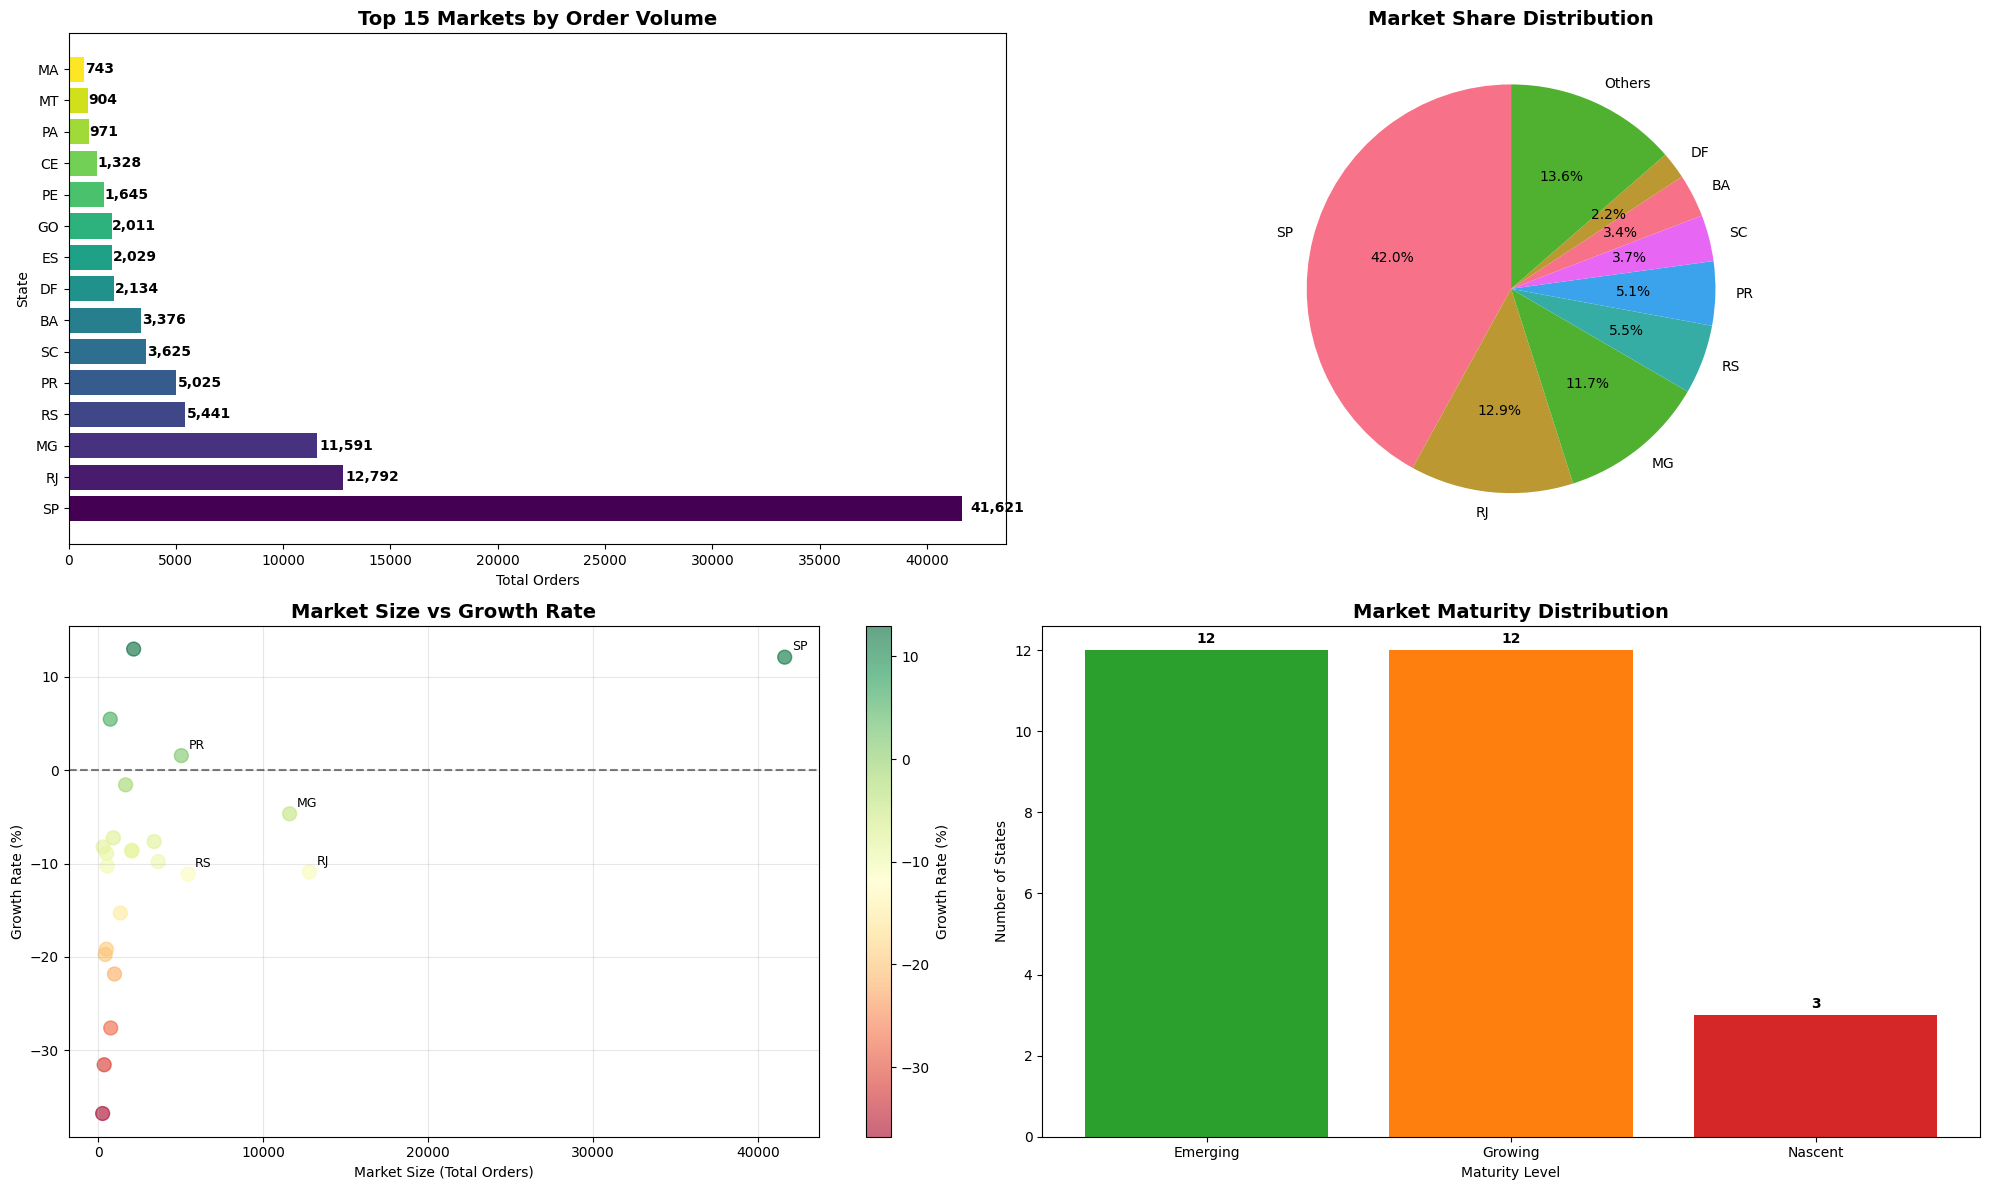

In [50]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 12))

top_15_states = regional_performance.head(15)
bars = ax1.barh(range(len(top_15_states)), top_15_states['total_orders'], 
               color=plt.cm.viridis(np.linspace(0, 1, len(top_15_states))))

ax1.set_title('Top 15 Markets by Order Volume', fontsize=14, fontweight='bold')
ax1.set_xlabel('Total Orders')
ax1.set_ylabel('State')
ax1.set_yticks(range(len(top_15_states)))
ax1.set_yticklabels(top_15_states['state'])

for i, (bar, orders) in enumerate(zip(bars, top_15_states['total_orders'])):
    width = bar.get_width()
    ax1.text(width + width*0.01, bar.get_y() + bar.get_height()/2.,
             f'{orders:,}', ha='left', va='center', fontweight='bold')

market_share_data = top_15_states.head(8)  # Top 8 for readability
other_share = regional_performance.iloc[8:]['market_share'].sum()

plot_data = list(market_share_data['market_share']) + [other_share]
plot_labels = list(market_share_data['state']) + ['Others']

wedges, texts, autotexts = ax2.pie(plot_data, labels=plot_labels, autopct='%1.1f%%', startangle=90)
ax2.set_title('Market Share Distribution', fontsize=14, fontweight='bold')

valid_growth_states = growth_analysis[growth_analysis['total_orders'] >= 200].copy()
scatter = ax3.scatter(valid_growth_states['total_orders'], 
                     valid_growth_states['growth_rate'],
                     s=100, alpha=0.6, c=valid_growth_states['growth_rate'], 
                     cmap='RdYlGn')

ax3.set_xlabel('Market Size (Total Orders)')
ax3.set_ylabel('Growth Rate (%)')
ax3.set_title('Market Size vs Growth Rate', fontsize=14, fontweight='bold')
ax3.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax3.grid(True, alpha=0.3)

plt.colorbar(scatter, ax=ax3, label='Growth Rate (%)')


for state, row in valid_growth_states.iterrows():
    if abs(row['growth_rate']) > 100 or row['total_orders'] > 5000:
        ax3.annotate(state, (row['total_orders'], row['growth_rate']),
                    xytext=(5, 5), textcoords='offset points', fontsize=9)

maturity_colors = {'Established': '#1f77b4', 'Growing': '#ff7f0e', 'Emerging': '#2ca02c', 'Nascent': '#d62728'}
bars = ax4.bar(range(len(maturity_analysis)), maturity_analysis['num_states'],
               color=[maturity_colors.get(level, 'gray') for level in maturity_analysis['maturity_level']])

ax4.set_title('Market Maturity Distribution', fontsize=14, fontweight='bold')
ax4.set_xlabel('Maturity Level')
ax4.set_ylabel('Number of States')
ax4.set_xticks(range(len(maturity_analysis)))
ax4.set_xticklabels(maturity_analysis['maturity_level'])

for bar, count in zip(bars, maturity_analysis['num_states']):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{count}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

<h5>Sao Paulo leads with 41,621 orders (42%), far ahead of Rio de Janeiro (12,792, 13%) and Minas Gerais (11,591, 12%), while most other states contribute less than 6,000 orders. This shows the market is heavily concentrated in Sao Paulo, creating high dependency. To balance growth, businesses should diversify into emerging states like Paraná and other growing regions, while also addressing decline in large markets such as Rio de Janeiro. Expanding beyond São Paulo will reduce risks and capture new demand.</h5>

<h1>3. Customer Behavior Patterns</h1>

In [51]:
customer_order_history = business_df.groupby('customer_unique_id').agg({
    'order_purchase_dt': ['count', 'min', 'max'],
    'customer_state': 'first'
}).reset_index()

customer_order_history.columns = ['customer_unique_id', 'total_orders', 'first_order', 'last_order', 'state']
customer_order_history['customer_type'] = customer_order_history['total_orders'].apply(
    lambda x: 'New Customer' if x == 1 else 'Returning Customer'
)

customer_order_history['days_active'] = (
    customer_order_history['last_order'] - customer_order_history['first_order']
).dt.days

customer_behavior = customer_order_history.groupby('customer_type').agg({
    'customer_unique_id': 'count',
    'total_orders': 'sum',
    'days_active': 'mean'
}).reset_index()

customer_behavior.columns = ['customer_type', 'customer_count', 'total_orders', 'avg_days_active']
customer_behavior['orders_per_customer'] = (
    customer_behavior['total_orders'] / customer_behavior['customer_count']
).round(2)
customer_behavior['customer_percentage'] = (
    customer_behavior['customer_count'] / customer_behavior['customer_count'].sum() * 100
).round(1)

<h3> Customer Lifecycle analysis</h3>

In [52]:
print(f"{'CUSTOMER TYPE':<18} {'COUNT':<8} {'% of Total':<12} {'TOTAL ORDERS':<15} {'ORDERS/CUSTOMER':<15}")

for _, row in customer_behavior.iterrows():
    print(f"{row['customer_type']:<18} {row['customer_count']:<8,} {row['customer_percentage']:<12}% "
          f"{row['total_orders']:<15,} {row['orders_per_customer']:<15}")

CUSTOMER TYPE      COUNT    % of Total   TOTAL ORDERS    ORDERS/CUSTOMER
New Customer       92,799   96.9        % 92,799          1.0            
Returning Customer 2,975    3.1         % 6,293           2.12           


In [53]:
def get_order_period(df):
    df['order_period'] = df['order_purchase_dt'].dt.to_period('M')
    df['cohort_group'] = df.groupby('customer_unique_id')['order_purchase_dt'].transform('min').dt.to_period('M')
    return df

business_df_cohort = get_order_period(business_df.copy())

# Create cohort table
cohort_data = business_df_cohort.groupby(['cohort_group', 'order_period'])['customer_unique_id'].nunique().reset_index()
cohort_counts = cohort_data.pivot(index='cohort_group', columns='order_period', values='customer_unique_id')

# Calculate retention rates
cohort_sizes = business_df_cohort.groupby('cohort_group')['customer_unique_id'].nunique()
retention_table = cohort_counts.divide(cohort_sizes, axis=0)

<H3> Customer Retention Insights</H3>

In [54]:
if len(retention_table.columns) > 1:
    period_1_retention = retention_table.iloc[:, 1].mean() * 100  # Month 1 retention
    if len(retention_table.columns) > 2:
        period_2_retention = retention_table.iloc[:, 2].mean() * 100  # Month 2 retention
    else:
        period_2_retention = None
        
    print(f"• Average Month 1 Retention Rate: {period_1_retention:.1f}%")
    if period_2_retention:
        print(f"• Average Month 2 Retention Rate: {period_2_retention:.1f}%")

• Average Month 1 Retention Rate: 50.2%
• Average Month 2 Retention Rate: 33.5%


<H3>Regional Customer Behavior</H3>

In [55]:
customer_geographic = customer_order_history.groupby(['state', 'customer_type']).agg({
    'customer_unique_id': 'count'
}).reset_index()

customer_geo_pivot = customer_geographic.pivot(index='state', columns='customer_type', values='customer_unique_id').fillna(0)
customer_geo_pivot['total_customers'] = customer_geo_pivot.sum(axis=1)
customer_geo_pivot['returning_rate'] = (
    customer_geo_pivot.get('Returning Customer', 0) / customer_geo_pivot['total_customers'] * 100
).round(1)

customer_geo_analysis = customer_geo_pivot[customer_geo_pivot['total_customers'] >= 100].sort_values('returning_rate', ascending=False)

print(f"{'STATE':<6} {'NEW':<8} {'RETURNING':<10} {'TOTAL':<8} {'RETURNING RATE %':<18}")

for state, row in customer_geo_analysis.head(10).iterrows():
    new_customers = int(row.get('New Customer', 0))
    returning_customers = int(row.get('Returning Customer', 0))
    total = int(row['total_customers'])
    returning_rate = row['returning_rate']
    
    print(f"{state:<6} {new_customers:<8,} {returning_customers:<10,} {total:<8,} {returning_rate:<18}")

STATE  NEW      RETURNING  TOTAL    RETURNING RATE %  
RO     229      10         239      4.2               
MT     842      30         872      3.4               
RJ     11,907   418        12,325   3.4               
GO     1,879    64         1,943    3.3               
RS     5,083    168        5,251    3.2               
SP     38,880   1,301      40,181   3.2               
DF     2,004    63         2,067    3.0               
AL     386      12         398      3.0               
ES     1,902    58         1,960    3.0               
MG     10,880   337        11,217   3.0               


<h3>Customer Behavior Visualization</h3>

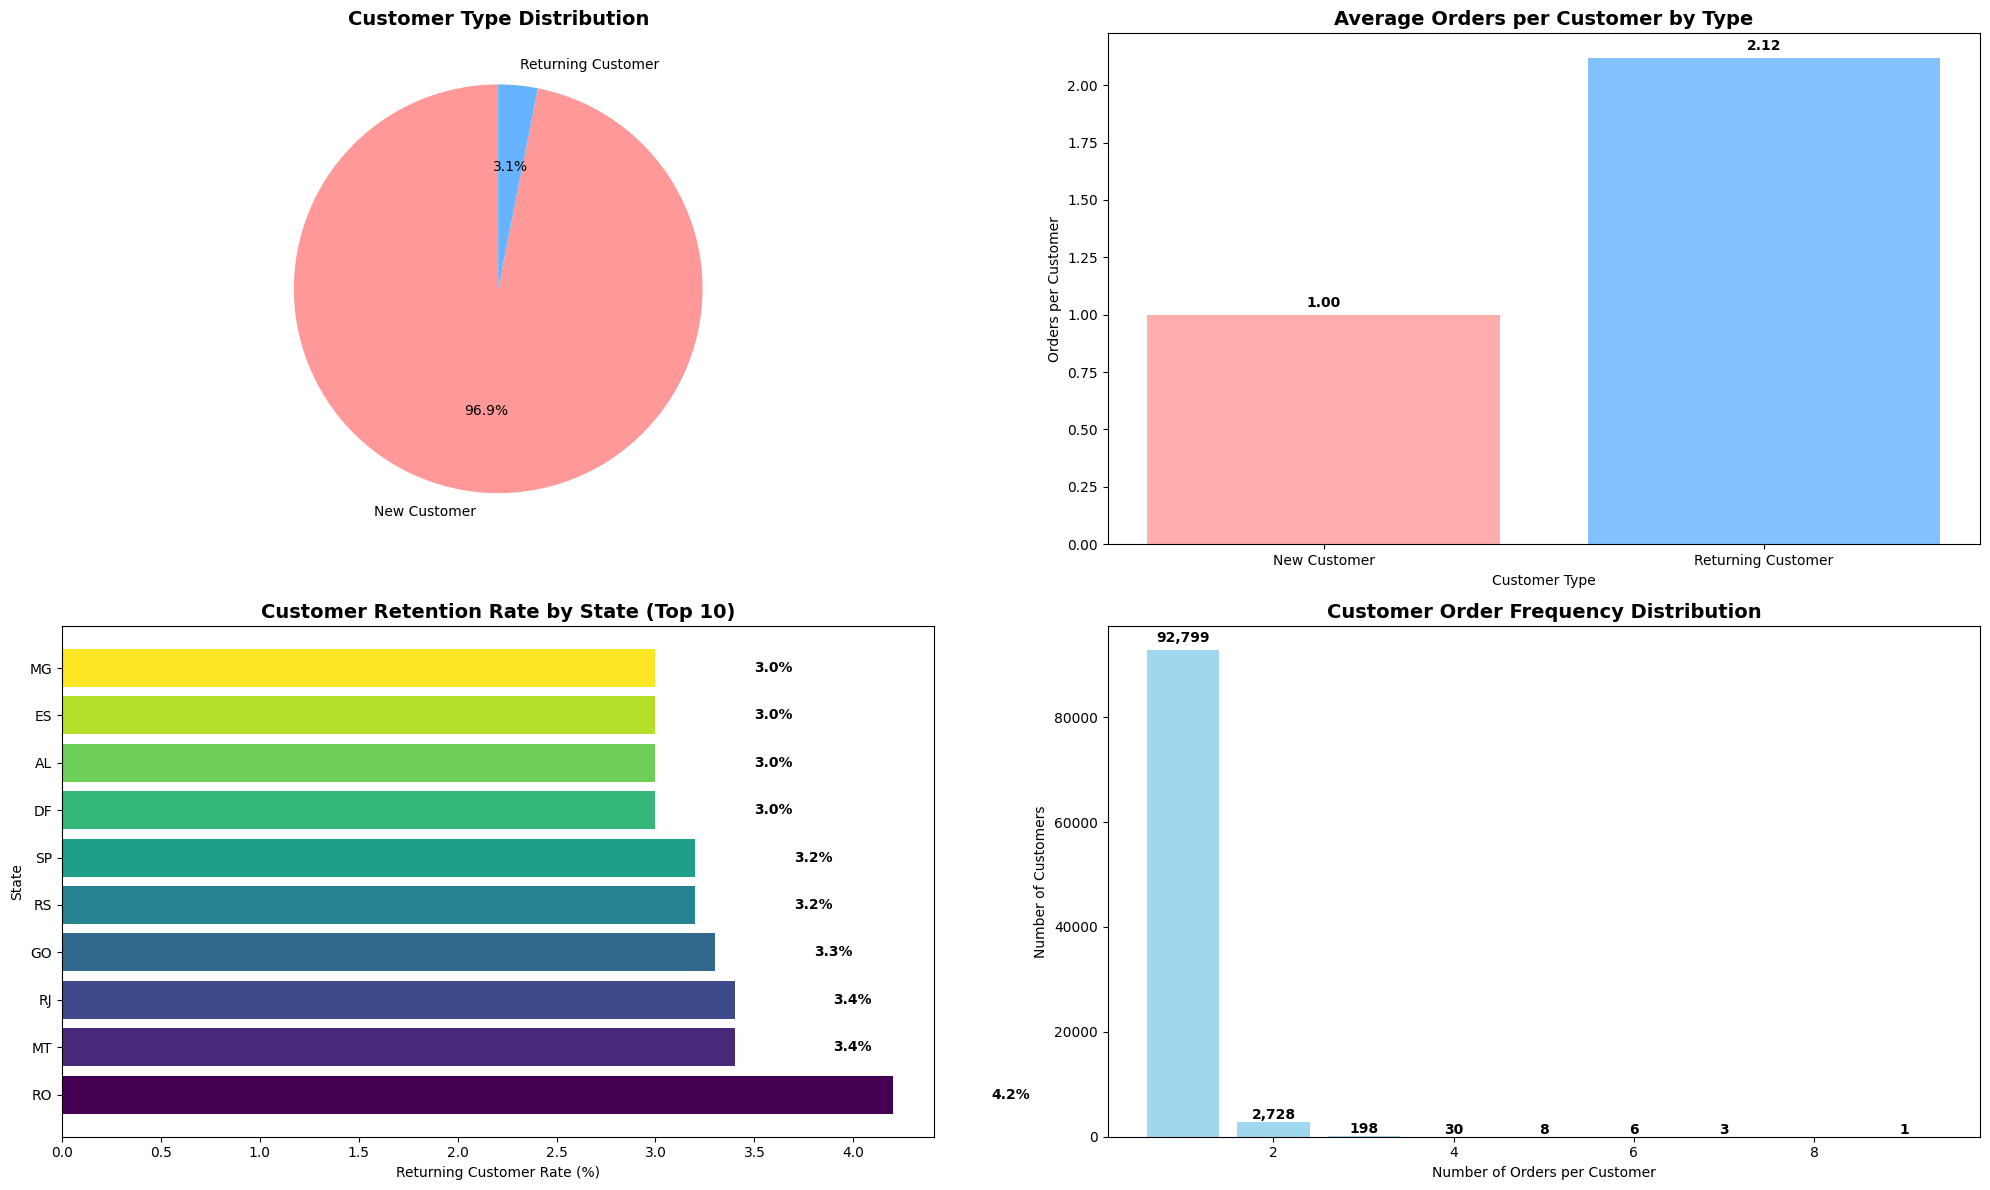

In [56]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 12))

# Plot 1: New vs Returning Customer Distribution
labels = customer_behavior['customer_type']
sizes = customer_behavior['customer_count']
colors = ['#ff9999', '#66b3ff']

wedges, texts, autotexts = ax1.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90)
ax1.set_title('Customer Type Distribution', fontsize=14, fontweight='bold')

# Plot 2: Orders per Customer by Type
bars = ax2.bar(customer_behavior['customer_type'], customer_behavior['orders_per_customer'], 
               color=colors, alpha=0.8)

ax2.set_title('Average Orders per Customer by Type', fontsize=14, fontweight='bold')
ax2.set_ylabel('Orders per Customer')
ax2.set_xlabel('Customer Type')

# Add value labels
for bar, orders in zip(bars, customer_behavior['orders_per_customer']):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.02,
             f'{orders:.2f}', ha='center', va='bottom', fontweight='bold')

# Plot 3: Customer Retention by State (Top 10)
top_retention_states = customer_geo_analysis.head(10)
bars = ax3.barh(range(len(top_retention_states)), top_retention_states['returning_rate'],
                color=plt.cm.viridis(np.linspace(0, 1, len(top_retention_states))))

ax3.set_title('Customer Retention Rate by State (Top 10)', fontsize=14, fontweight='bold')
ax3.set_xlabel('Returning Customer Rate (%)')
ax3.set_ylabel('State')
ax3.set_yticks(range(len(top_retention_states)))
ax3.set_yticklabels(top_retention_states.index)

# Add value labels
for i, (bar, rate) in enumerate(zip(bars, top_retention_states['returning_rate'])):
    width = bar.get_width()
    ax3.text(width + 0.5, bar.get_y() + bar.get_height()/2.,
             f'{rate:.1f}%', ha='left', va='center', fontweight='bold')

# Plot 4: Customer Order Frequency Distribution
order_frequency = customer_order_history['total_orders'].value_counts().sort_index()
order_frequency = order_frequency[order_frequency.index <= 10]  # Limit to 10+ for readability

bars = ax4.bar(order_frequency.index, order_frequency.values, alpha=0.8, color='skyblue')
ax4.set_title('Customer Order Frequency Distribution', fontsize=14, fontweight='bold')
ax4.set_xlabel('Number of Orders per Customer')
ax4.set_ylabel('Number of Customers')

# Add value labels
for bar, count in zip(bars, order_frequency.values):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
             f'{count:,}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

<h5>Customer retention is a major challenge, with 96.9% of buyers purchasing only once and just 3.1% returning, though those who do come back place twice as many orders (2.12 vs 1.0). Retention is consistently weak across all states, with the best still only at 4.2%. This highlights the need to encourage repeat purchases through strategies like personalized offers, loyalty rewards, and post-purchase engagement, as even a small increase in returning customers could significantly boost overall sales.</h5>

In [63]:
from IPython.display import display, Markdown

report = "## BUSINESS PERFORMANCE RECOMMENDATIONS\n\n"

# --- 1. Customer Retention by State ---
# Retention: unique customers who returned in consecutive months (m0->m1)
cohort = business_df.groupby(['customer_unique_id', 'order_year_month', 'customer_state'])['order_id'].nunique().reset_index()

# Mark customers' first purchase per state
cohort['first_purchase'] = cohort.groupby(['customer_unique_id', 'customer_state'])['order_year_month'].transform('min')

# Retained if they purchased again after first_purchase
retention = cohort.groupby('customer_state').apply(
    lambda g: (g[g['order_year_month'] > g['first_purchase']]['customer_unique_id'].nunique() /
               g['customer_unique_id'].nunique()) if g['customer_unique_id'].nunique() > 0 else 0
).reset_index(name='retention_rate')

retention_sorted = retention.sort_values('retention_rate', ascending=False)
best_state = retention_sorted.iloc[0]
worst_state = retention_sorted.iloc[-1]

report += "### 1. Customer Retention by State\n"
report += f"- **Top Performer:** {best_state['customer_state']} with retention rate of **{best_state['retention_rate']:.1%}**  \n"
report += f"- **Weakest Performer:** {worst_state['customer_state']} with retention rate of **{worst_state['retention_rate']:.1%}**  \n"
report += "- **Recommendation:** Strengthen weak states with localized campaigns (loyalty discounts, free shipping).  \n\n"

# --- 2. Orders per Customer ---
orders_per_customer = business_df.groupby('customer_unique_id')['order_id'].nunique().mean()
report += "### 2. Orders per Customer\n"
report += f"- Average orders per customer: **{orders_per_customer:.2f}**  \n"
report += "- **Recommendation:** Encourage repeat purchases with cross-selling, subscriptions, and tailored promotions.  \n\n"

# --- 3. Emerging States (growth in new customers) ---
first_orders = business_df.groupby(['customer_unique_id'])['order_year_month'].min().reset_index()
first_orders = first_orders.merge(business_df[['customer_unique_id','customer_state']], on='customer_unique_id', how='left').drop_duplicates('customer_unique_id')

state_new_customers = first_orders.groupby('customer_state')['customer_unique_id'].nunique().reset_index(name='new_customers')
emerging_states = state_new_customers.sort_values('new_customers', ascending=False).head(3)

report += "### 3. Emerging States with New Customer Growth\n"
for _, row in emerging_states.iterrows():
    report += f"- {row['customer_state']}: **{row['new_customers']} new customers**  \n"
report += "- **Recommendation:** Invest in marketing and logistics to capture momentum in these states.  \n\n"

# --- 4. Underperforming States (low retention + low new customers) ---
low_retention_threshold = retention['retention_rate'].quantile(0.25)
low_new_threshold = state_new_customers['new_customers'].quantile(0.25)

underperforming = retention.merge(state_new_customers, on='customer_state')
underperforming = underperforming[
    (underperforming['retention_rate'] <= low_retention_threshold) &
    (underperforming['new_customers'] <= low_new_threshold)
].sort_values('retention_rate')

report += "### 4. Underperforming States\n"
if not underperforming.empty:
    for _, row in underperforming.iterrows():
        report += f"- {row['customer_state']}: retention **{row['retention_rate']:.1%}**, only **{row['new_customers']} new customers**  \n"
    report += "- **Recommendation:** Evaluate ROI in these states. If strategic, improve infrastructure/logistics; if not, prioritize higher-performing markets.  \n\n"
else:
    report += "- No critically underperforming states detected.  \n\n"

# --- 5. Strategic Outlook ---
report += "### 5. Strategic Outlook\n"
report += "- Retention improvements (even +5–10%) can significantly boost revenue without extra acquisition cost.  \n"
report += "- Focus on **emerging states** for growth while addressing **underperforming states** strategically.  \n"
report += "- Apply segmentation (e.g., RFM analysis) to sharpen retention and acquisition efforts.  \n"

display(Markdown(report))


## BUSINESS PERFORMANCE RECOMMENDATIONS

### 1. Customer Retention by State
- **Top Performer:** AC with retention rate of **3.9%**  
- **Weakest Performer:** CE with retention rate of **0.9%**  
- **Recommendation:** Strengthen weak states with localized campaigns (loyalty discounts, free shipping).  

### 2. Orders per Customer
- Average orders per customer: **1.03**  
- **Recommendation:** Encourage repeat purchases with cross-selling, subscriptions, and tailored promotions.  

### 3. Emerging States with New Customer Growth
- SP: **40181 new customers**  
- RJ: **12325 new customers**  
- MG: **11217 new customers**  
- **Recommendation:** Invest in marketing and logistics to capture momentum in these states.  

### 4. Underperforming States
- SE: retention **1.2%**, only **337 new customers**  
- **Recommendation:** Evaluate ROI in these states. If strategic, improve infrastructure/logistics; if not, prioritize higher-performing markets.  

### 5. Strategic Outlook
- Retention improvements (even +5–10%) can significantly boost revenue without extra acquisition cost.  
- Focus on **emerging states** for growth while addressing **underperforming states** strategically.  
- Apply segmentation (e.g., RFM analysis) to sharpen retention and acquisition efforts.  
